# Pima Indians Diabetes Analysis    

In this notebook I conduct an analysis of Pima Indians Diabetes Database. My goals are to:
- Understand the data
- Wrangle those data
- Build a model that can predict diabetes

This model will be later use as a base of Diabetes Predictor app, that will be deploy using streamlit engine. This is in fact the main goal of my project as a whole.

Github repo URL: https://github.com/Niklewa/Diabetes_pima_indians



Tools preparation:

In [ ]:
!pip install pycaret


In [ ]:
!pip install scikit-learn

In [ ]:
# without it
!pip install pandas
!pip install numpy

In [ ]:
#!pip install shap


In [ ]:
!pip install joblib

In [7]:
import pycaret
pycaret.__version__

'2.3.10'

In [ ]:
#For Clustering
from pycaret.classification import *

In [4]:
import sklearn
sklearn.__version__

'0.23.2'

In [5]:
# Importing and aliasing files

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from scipy.stats import norm, skew
import joblib

In [114]:
# needed
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_validate

In [ ]:
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.feature_selection import SelectFromModel

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

## Loading the data

Data documentation:     

source URL: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database    

**Variables description**:

- Pregnancies: Number of times pregnant     
- Glucose level: Plasma glucose concentration a 2 hours in an oral glucose tolerance test     
- Blood Pressure: Diastolic blood pressure (mm Hg)     
- Skin Thickness: Triceps skin fold thickness (mm)     
- Insulin level: 2-Hour serum insulin (mu U/ml)    
- BMI: Body mass index (weight in kg/(height in m)^2)    
- Diabetes Pedigree Function: Diabetes pedigree function    
- Age: Age (years)    
- Outcome: 1 for diabetes, 0 for a person free from diabetes

In [97]:
diab_df = pd.read_csv("diabetes.csv")
display(diab_df.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [98]:
# Checking if there are any NaN values
print(diab_df.isnull().values.any())

False


In [99]:
# Checking out data types
print(diab_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


In [100]:
# Let's check unique values of pregnancy variable, if there are any that could indicate being a male

print(diab_df.Pregnancies.unique())

# Unfortunately it is not possible to determine sex of a person in this data set, 0 have an ambigoues meaning, it can stand for man or a woman.
# Therefore we cannot take into account gender factor

[ 6  1  8  0  5  3 10  2  4  7  9 11 13 15 17 12 14]


In [ ]:
# Lets see how the data looks like

In [106]:
# Defining function and variables for visualization purposes

col_names = list(diab_df.columns)
col_names.remove('Outcome')

pairs = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1)]

def hist_fun_dist(x, z):
 
     fig, axs = plt.subplots(4, 2, figsize=(14, 14))

     for z, i in zip(pairs, col_names):
           sns.histplot(x[i], color='#03045e', kde=True, stat="density", linewidth=0, ax=axs[z])
        
     fig.tight_layout(pad=3.0)
     plt.show()

In [ ]:
hist_fun_dist(diab_df)

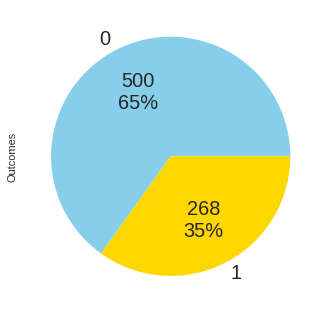

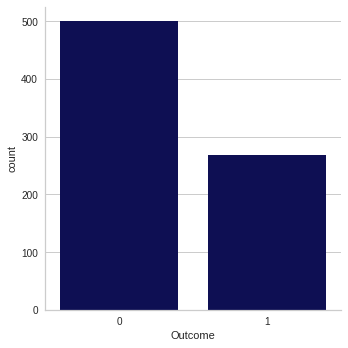

In [78]:
# Let's also see how many people have diabetes

def label_function(val):
    return f'{val / 100 * len(diab_df):.0f}\n{val:.0f}%'

diab_df.groupby('Outcome').size().plot(kind='pie',  textprops={'fontsize': 20}, autopct=label_function,
                                 colors=['skyblue', 'gold'], label='Outcomes')

sns.catplot(data=diab_df, x='Outcome', color='#03045e', kind="count")

plt.show()




As you can see on histograms there are some outliers. In many cases 0 values does not make sense, therefore we will substiture them with mean. But before doing that, let's run some outlier test.

In [93]:
#IQR outlier finding function

def iqr_outliers(df):
    out=[]
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    for i in df:
        if i > Upper_tail or i < Lower_tail:
            out.append(i)
    return("Outliers:",out)
    

In [95]:
# IQR test for variables

for z in col_names:
  print(f"{iqr_outliers(diab_df[z])} of {z}")


('Outliers:', [15, 17, 14, 14]) of Pregnancies
('Outliers:', [0, 0, 0, 0, 0]) of Glucose
('Outliers:', [0, 0, 30, 110, 0, 0, 0, 0, 108, 122, 30, 0, 110, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 108, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 110, 0, 24, 0, 0, 0, 0, 114, 0, 0, 0]) of BloodPressure
('Outliers:', [99]) of SkinThickness
('Outliers:', [543, 846, 342, 495, 325, 485, 495, 478, 744, 370, 680, 402, 375, 545, 360, 325, 465, 325, 415, 579, 474, 328, 480, 326, 330, 600, 321, 440, 540, 480, 335, 387, 392, 510]) of Insulin
('Outliers:', [0.0, 0.0, 0.0, 0.0, 53.2, 55.0, 0.0, 67.1, 52.3, 52.3, 52.9, 0.0, 0.0, 59.4, 0.0, 0.0, 57.3, 0.0, 0.0]) of BMI
('Outliers:', [2.288, 1.441, 1.39, 1.893, 1.781, 1.222, 1.4, 1.321, 1.224, 2.329, 1.318, 1.213, 1.353, 1.224, 1.391, 1.476, 2.137, 1.731, 1.268, 1.6, 2.42, 1.251, 1.699, 1.258, 1.282, 1.698, 1.461, 1.292, 1.394]) of DiabetesPedigreeFunction
('Outliers:', [69, 67, 72, 81, 67, 67, 70, 68, 69]) of Age


IQR test showed us relatively many (in some cases) hyphotetical outlier values. Although the data is relatively small, I decided to just leave all values apart from 0s.   
The statistical test is only a tool, and should not determine statistican's act. Look for example on the Age outliers, it totally makes sense to be 67 of age :)        
Therefore let's don't interfere too much. 


In [101]:
# replacing 0s
col_names_sel = ['BMI', 'Glucose', 'BloodPressure', 'Insulin', 'SkinThickness']
diab_df_mod = diab_df

for x in col_names_sel:
    
    diab_df_mod[x] = diab_df_mod[x].replace(0, diab_df_mod[x].mean())


Let's see how getting rid of zeros worked out

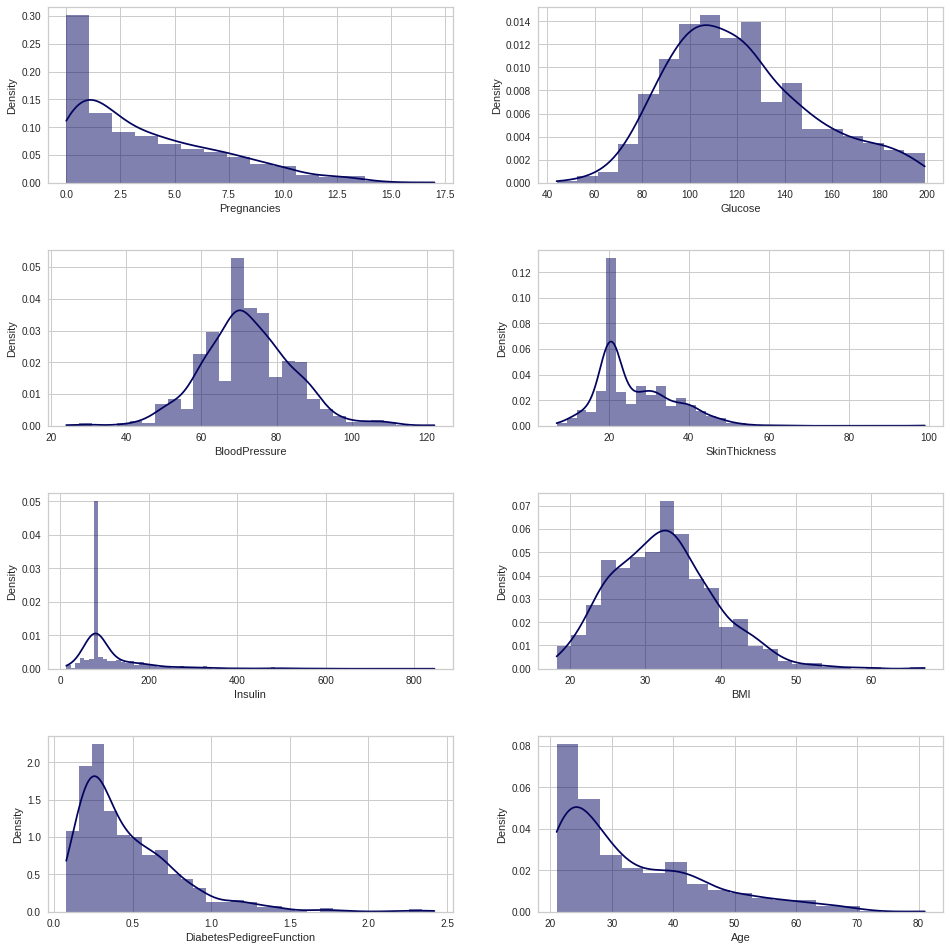

In [ ]:
hist_fun_dist(diab_df_mod)

It makes more good than harm

Now let's get serious and check some dependencies between data, the most important will be of course correlation. We will check how other variables influence the possibility of having diabetes.

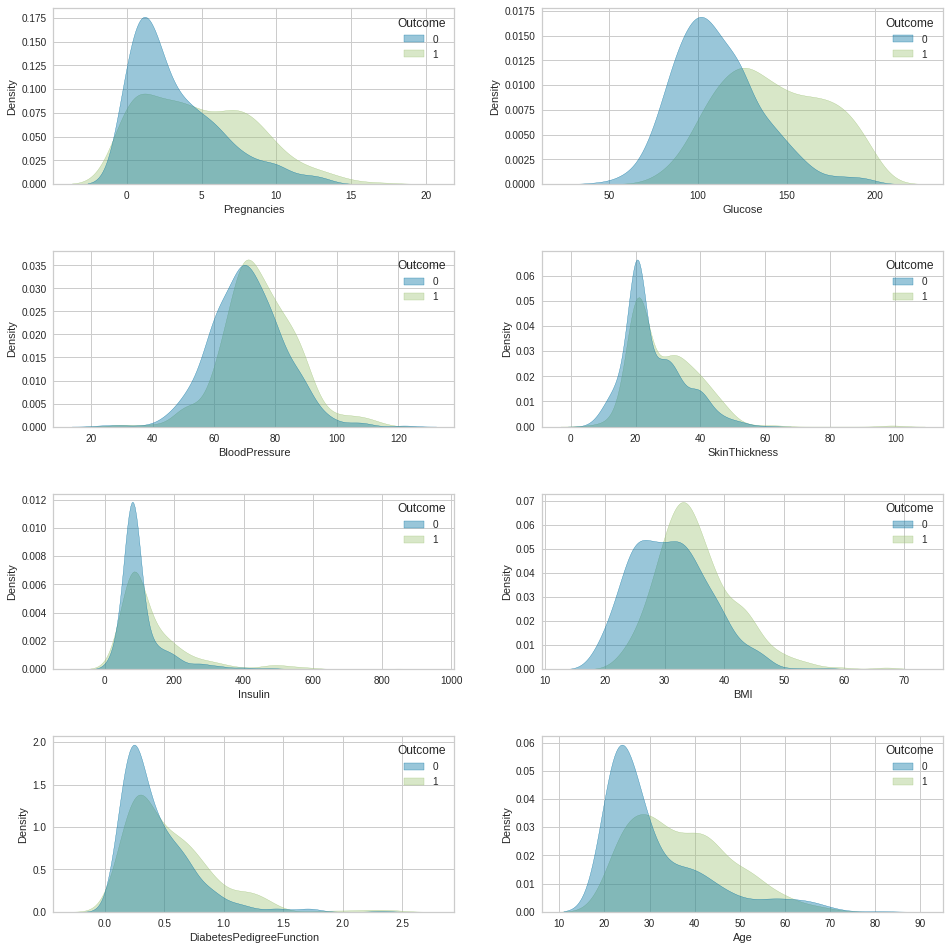

In [102]:
# Let's run a visualizations
fig, axs = plt.subplots(4, 2, figsize=(14, 14))

for z, i in zip(pairs, col_names):
       sns.kdeplot(data=diab_df, x=diab_df[i], hue="Outcome", fill=True, common_norm=False, alpha=0.4, ax=axs[z])
        
fig.tight_layout(pad=3.0)


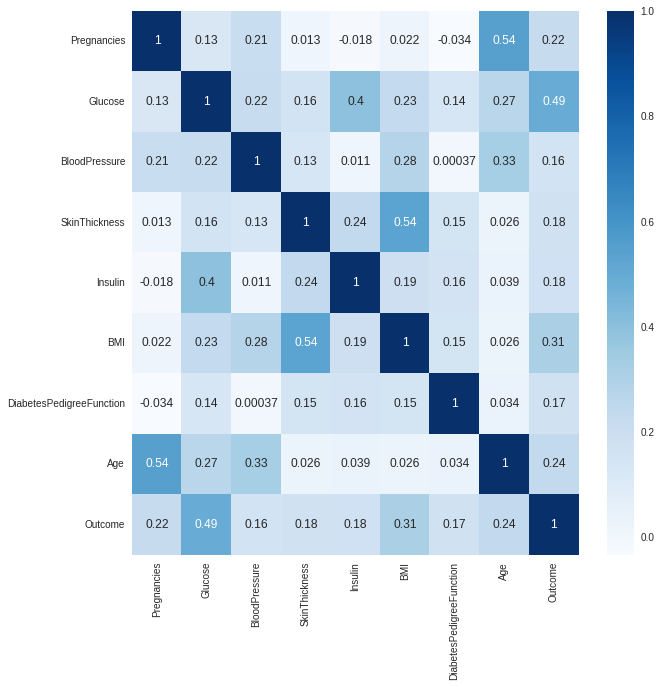

In [104]:
# and a classical correlation test (Pearson's correlation)

correlation_diab_matrix = diab_df_mod.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_diab_matrix, cbar=True, annot=True, cmap='Blues')
plt.savefig('Correlation Heat map')

The good news is that this correlations makes sense! Look on the correlation between Age and Pregnancies or BMI and Skin Thickness, they are pretty obvious.    
What interest us the most are the factors that have influence on the Outcome. Glucose level and BMI are the best ones. 

# Creating model

In [ ]:
# ML 
# With 10 corss-validation folds
# Creating setup for adjudidication between models

diab1 = setup(data = diab_df_mod, target = 'Outcome', numeric_features=col_names, fold=10,
              normalize=True,  session_id=1)

In [111]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7689,0.8106,0.5579,0.7060,0.6211,0.4586,0.4666,0.421
ridge,Ridge Classifier,0.7653,0.0000,0.5474,0.7016,0.6124,0.4484,0.4571,0.013
lda,Linear Discriminant Analysis,0.7653,0.8102,0.5526,0.6976,0.6145,0.4497,0.4574,0.018
rf,Random Forest Classifier,0.7616,0.8139,0.5678,0.6841,0.6132,0.4453,0.4532,0.509
gbc,Gradient Boosting Classifier,0.7542,0.8143,0.5901,0.6618,0.6195,0.4398,0.4444,0.130
nb,Naive Bayes,0.7357,0.7823,0.5579,0.6323,0.5902,0.3965,0.3999,0.014
qda,Quadratic Discriminant Analysis,0.7320,0.7681,0.5421,0.6283,0.5792,0.3848,0.3889,0.023
et,Extra Trees Classifier,0.7317,0.8024,0.5187,0.6276,0.5631,0.3740,0.3796,0.541
ada,Ada Boost Classifier,0.7282,0.7883,0.5804,0.6085,0.5915,0.3888,0.3909,0.121
lightgbm,Light Gradient Boosting Machine,0.7244,0.7873,0.5632,0.6037,0.5772,0.3751,0.3786,0.158


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Logistic regression seems to be our fit! And it makes sense, because we are trying to predict binary outcome. Therefore ler's train a logistic regression model.

In [115]:
# full lr model (not corss-val)

y = diab_df_mod["Outcome"]
X = diab_df_mod.drop(["Outcome"], axis=1)

log_model_diab = LogisticRegression().fit(X, y)

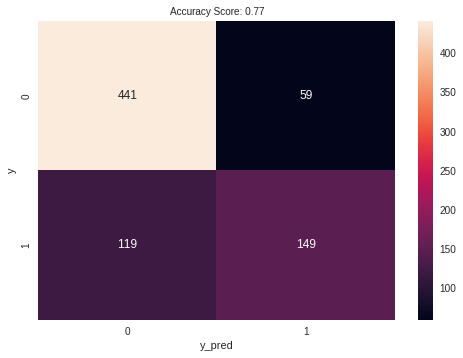

In [117]:
# confusion matrix diffferently created model

cv_results = cross_validate(log_model_diab,
                            X, y,
                            cv=10,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

y_pred = log_model_diab.predict(X)

def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y, y_pred)




Maybe 77% accuracy isn't the highest, but it's not bad at all also.

In [120]:
print(classification_report(y, y_pred))

y_prob = log_model_diab.predict_proba(X)[:, 1]
print(roc_auc_score(y, y_prob))


              precision    recall  f1-score   support

           0       0.79      0.88      0.83       500
           1       0.72      0.56      0.63       268

    accuracy                           0.77       768
   macro avg       0.75      0.72      0.73       768
weighted avg       0.76      0.77      0.76       768

0.8324402985074628


The ROC value, which is very important when it comes to binary casification, is pretty decent. Without a shame we can use this model as a diabetes predictor.

## Saving the model

I am using joblib in order to save and move the model into a different environment. I will use it in pycharm in order to create a streamlit web app that can predict if a person have diabetes. This kind of operation needs to be done on the desktop enviromnment.


In [ ]:
filename = 'lr_diab_model.pkl'
joblib.dump(log_model_diab, filename)

App URL: https://niklewa-diabetes-pima-india-to-appstreamlit-diabetes-app-olsxpm.streamlitapp.com/